# Definindo os agentes Codificador e Revisor

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Verifica se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LLMAgent:
    def __init__(self, model_name="distilgpt2", agent_type="codificador"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
        self.agent_type = agent_type
        self.history = []
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id

    def generate_code(self, prompt):
        inputs = self.tokenizer.encode_plus(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )

        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        outputs = self.model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=100,
            num_return_sequences=1,
            pad_token_id=self.tokenizer.pad_token_id
        )

        result = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        self.history.append({"prompt": prompt, "result": result})
        return result

    def review_code(self, code):
        review_prompt = f"Reveja o seguinte código e sugira melhorias:\n\n{code}"
        return self.generate_code(review_prompt)


In [3]:
device

device(type='cuda')

# Definindo o ambiente para os agentes interagirem

In [ ]:
#!pip install timeout_decorator

# verificar se é necessario mesmo desse pacote

In [4]:
# Utilizaremos a biblioteca Gym para definir um ambiente onde os agentes possam interagir.
#  A função do ambiente é atribuir recompensas com base na qualidade do código e do feedback.

import ast
import matplotlib.pyplot as plt
import io
import gym
from gym import spaces
import numpy as np
import random
from timeout_decorator import timeout, TimeoutError
import signal


class DataAnalysisEnv(gym.Env):
    def __init__(self, datasets, tasks, codificador, revisor, test_dataset=None):
        super(DataAnalysisEnv, self).__init__()

        self.codificador = codificador
        self.revisor = revisor
        self.datasets = datasets
        self.test_dataset = test_dataset
        self.tasks = tasks
        self.reset_task_and_dataset()

        self.current_state = 0
        self.max_steps = 10
        self.steps_taken = 0
        self.done = False
        self.current_code = ""

        self.error_logged = set()  # Para registrar erros únicos
        self.verbose_logging = False  # Alterar para True para mais detalhes

        # Adicionando um atributo de histórico
        self.history = []

        # Definindo o espaço de observação e espaço de ação
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

    def reset_task_and_dataset(self):
        self.current_task = random.choice(list(self.tasks.keys()))
        self.dataset = random.choice(self.datasets)

    def reset(self):
        self.reset_task_and_dataset()
        self.current_state = 0
        self.steps_taken = 0
        self.done = False
        self.current_code = ""
        return np.array([self.current_state], dtype=np.float32)

    def step(self, action):
        self.steps_taken += 1
        reward = 0

        if action == 0:
            new_code = self.codificador.generate_code(f"Dados: {self.dataset}\nTarefa: {self.tasks[self.current_task]['description']}")
            self.current_code += new_code
            reward = -1

        elif action == 1:
            feedback = self.revisor.review_code(self.current_code)
            reward = 1

        elif action == 2:
            if self._evaluate_solution():
                reward = 10
            else:
                reward = -10
            self.done = True

        self.current_state = self.steps_taken / self.max_steps
        if self.steps_taken >= self.max_steps:
            self.done = True

        # Atualizando o histórico
        self.history.append({'reward': reward, 'steps': self.steps_taken, 'state': self.current_state})

        if self.verbose_logging:
            print(f"Ação executada: {action}, Estado atual: {self.current_state:.2f}, Recompensa: {reward}, Done: {self.done}")

        return np.array([self.current_state], dtype=np.float32), reward, self.done, {}

    def _evaluate_solution(self):
        task_info = self.tasks[self.current_task]
        required_components = task_info["required_components"]

        try:
            tree = ast.parse(self.current_code)
        except SyntaxError as e:
            error_message = f"Erro de sintaxe: {e}"
            if error_message not in self.error_logged:
                self.error_logged.add(error_message)
            return False

        components_found = set()
        for node in ast.walk(tree):
            if isinstance(node, ast.Call) and isinstance(node.func, ast.Attribute):
                if node.func.attr == 'plot' and 'line_chart' in required_components:
                    components_found.add('line_chart')
                if node.func.attr == 'scatter' and 'scatter_plot' in required_components:
                    components_found.add('scatter_plot')
                if node.func.attr == 'hist' and 'histogram' in required_components:
                    components_found.add('histogram')

        if not components_found:
            message = "Nenhuma função de visualização necessária foi encontrada no código."
            if message not in self.error_logged:
                self.error_logged.add(message)
            return False

        # Configura o timeout
        signal.signal(signal.SIGALRM, self.handler)
        signal.alarm(5)  # Define o tempo limite para 5 segundos

        try:
            buf = io.BytesIO()
            plt.switch_backend('Agg')
            exec(self.current_code, {"plt": plt, "io": io, "buf": buf})

            if buf.tell() == 0:
                if "Nenhum gráfico foi gerado." not in self.error_logged:
                    self.error_logged.add("Nenhum gráfico foi gerado.")
                return False

            buf.close()

        except TimeoutError:
            print("Execução do código excedeu o tempo limite.")
            return False

        except Exception as e:
            print(f"Erro ao executar o código: {e}")
            return False
        finally:
            signal.alarm(0)  # Cancela o alarme

        print("Código gerado corretamente e pelo menos um gráfico foi plotado.")
        return True

    def handler(self, signum, frame):
        """Função chamada quando o tempo limite é atingido."""
        raise TimeoutError

# Codificador e Revisor no Ambiente: O ambiente recebe o codificador e o revisor como parâmetros e usa suas funções para gerar e revisar o código em cada passo.

# Ação do Codificador: Quando o agente decide continuar gerando código (action == 0), a função generate_code do Codificador é chamada e o código é atualizado no ambiente.

# Ação do Revisor: Quando o agente decide revisar o código (action == 1), o Revisor revisa o código gerado e sugere melhorias.

# Finalizar: Se o agente decide finalizar o processo (action == 2), a função de avaliação compara o código atual com a solução esperada e atribui uma recompensa dependendo do resultado.

# Treinamento dos agentes

In [ ]:
#!pip install stable_baselines3

In [5]:
# Usaremos a biblioteca stable-baselines3 para realizar o treinamento dos agentes.
# Usaremos o algoritmo PPO (Proximal Policy Optimization), que é adequado para esse tipo de problema

from stable_baselines3 import PPO
import torch

def train_agents():
    """
    Treina os agentes codificador e revisor no ambiente de análise de dados.
    """
    # Instanciando os agentes LLM
    codificador = LLMAgent(agent_type="codificador")
    revisor = LLMAgent(agent_type="revisor")

    # Instanciando o ambiente de RL
    env = DataAnalysisEnv(datasets, tasks, codificador, revisor)

    # Configurando o modelo de RL PPO para usar GPU, se disponível
    model = PPO("MlpPolicy", env, verbose=1, device=device)

    # Treinamento do agente
    model.learn(total_timesteps=10000)

    # Visualizando o progresso durante o treinamento
    visualize_progress(env.history)

    return env, model

def test_agent(env, model):
    """
    Testa o agente treinado em um novo episódio e exibe seu desempenho.
    """
    env.datasets = [env.test_dataset]  # Usar apenas o dataset de teste
    obs = env.reset()
    done = False
    env.history = []  # Resetando o histórico para o teste

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

        # Salvando a interação para visualização posterior
        env.history.append({
            'state': obs,
            'reward': reward,
            'action': action
        })

        print(f"Recompensa: {reward}, Estado: {obs}")

    # Visualiza o progresso após o teste
    visualize_progress(env.history)

def visualize_progress(history):
    """
    Exibe o progresso do agente ao longo do tempo, com base nas interações e recompensas recebidas.
    """
    rewards = [entry['reward'] for entry in history]
    plt.plot(rewards)
    plt.title("Progresso do Agente")
    plt.xlabel("Passos")
    plt.ylabel("Recompensa")
    plt.show()


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
#!pip install gymnasium==0.29
#!pip install shimmy==1.3.0

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.85     |
|    ep_rew_mean     | -9.96    |
| time/              |          |
|    fps             | 3        |
|    iterations      | 1        |
|    time_elapsed    | 656      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.48        |
|    ep_rew_mean          | -8.56       |
| time/                   |             |
|    fps                  | 2           |
|    iterations           | 2           |
|    time_elapsed         | 1427        |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.043380864 |
|    clip_fraction        | 0.453       |
|    clip_range           | 0.2         |
|    entropy_loss  

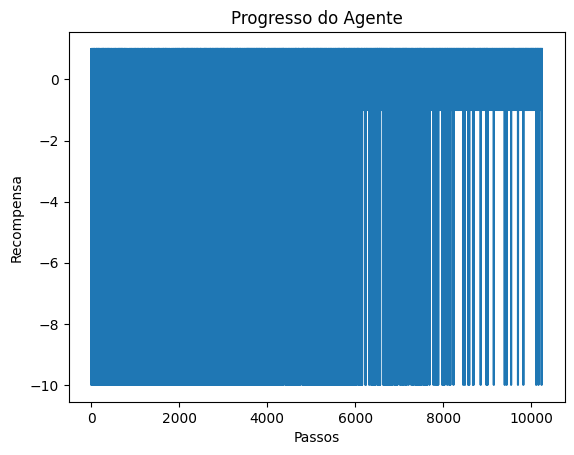

Recompensa: 1, Estado: [0.1]
Recompensa: 1, Estado: [0.2]
Recompensa: 1, Estado: [0.3]
Recompensa: 1, Estado: [0.4]
Recompensa: 1, Estado: [0.5]
Recompensa: 1, Estado: [0.6]
Recompensa: 1, Estado: [0.7]
Recompensa: 1, Estado: [0.8]
Recompensa: 1, Estado: [0.9]
Recompensa: 1, Estado: [1.]


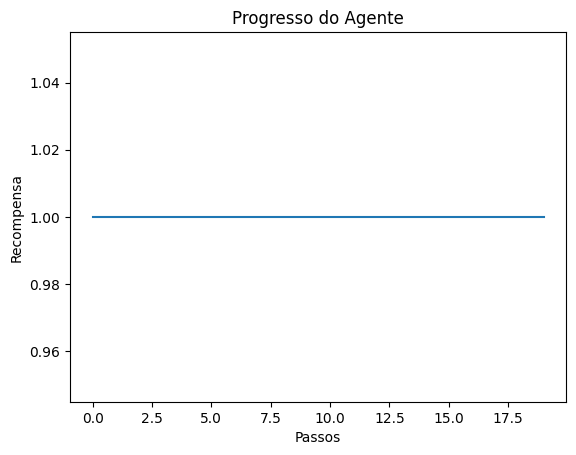

In [7]:
# Datasets e Tarefas
datasets = ["/content/Walmart.csv", "/content/bestsellers with categories.csv",
            "/content/bestsellers_categories.csv","/content/sell_house.csv",
            "/content/sell_phones.csv"]  # Datasets de treino

test_dataset = "/content/laptop_price.csv"  # Dataset de teste

tasks = {
    "visualization": {
        "description": "Gerar gráficos com dados.",
        "required_components": ["line_chart", "scatter_plot", "histogram"]
    }
}

# Treina os agentes
env, model = train_agents()

# Atualiza o ambiente com o dataset de teste
env.test_dataset = test_dataset

# Testa o agente treinado
test_agent(env, model)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')